## Project to Weed Detection in Soybean Crops
#### The dataset was get in [Kaggle](https://www.kaggle.com/fpeccia/weed-detection-in-soybean-crops)

### Steps
#### Configuration
- Download dataset
- Configure os enviroments
- Imports dependencies
- Create global variables
- Get images from dataset
- Show image
- Split dataset to train and test

#### Start Learning with Keras
- Import keras
- Create callbacks (savePoint, reduce)
- Create a model for CNN
- Compile model
- Load model if exists
- Train model
- Evaluate model
- Fit model
- Show results

#### Reference :
[Kaggle notebook](https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97)

In [1]:
import os   
os.environ['HDF5_DISABLE_VERSION_CHECK']='1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Imports here
#https://www.kaggle.com/datduyn/2-layer-net-on-weeds-discriminant/
##https://www.kaggle.com/harshel7/detecting-malaria-val-accuracy-97
import cv2                 
import numpy as np   
import glob
import matplotlib.pyplot as plt 

In [3]:
data_dir = r'dataset/'
classes = ['broadleaf', 'grass', 'soil', 'soybean'] 
width = 128
height = 128
channel = 3

num_file_per_directory = 1200 

all_files = [] 
for i, cls in enumerate(classes):
    all_files += [f for f in glob.glob(data_dir+cls+'/*.tif')][:num_file_per_directory]
    
print('Files size:', len(all_files))

data = []
labels = []
for idx, file in enumerate(all_files):
    img_array = cv2.resize(cv2.imread(file), (width, height))
    data.append(img_array)
    if 'broadleaf' in file :
        labels.append(0)
    elif 'grass' in file :
        labels.append(1)
    elif 'soil' in file :
        labels.append(2)
    else :
        labels.append(3)


Files size: 4791


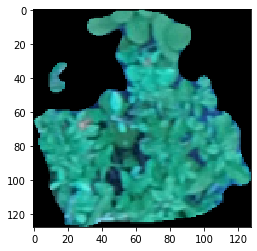

In [4]:
plt.imshow(data[0])
plt.show()

In [5]:
image_data = np.array(data)
labels = np.array(labels)
idx = np.arange(image_data.shape[0])
np.random.shuffle(idx)
image_data = image_data[idx]
labels = labels[idx]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size = 0.2, random_state = 101)

### Start Learning with Keras

Documantation [keras](https://keras.io/)

In [6]:
from keras.utils import np_utils
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint

y_train = np_utils.to_categorical(y_train, num_classes = 4)
y_test = np_utils.to_categorical(y_test, num_classes = 4)

D:\Programas\Anaconda3\lib\site-packages\h5py\__init__.py:75: UserWarning: h5py is running against HDF5 1.10.5 when it was built against 1.10.4, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.


In [7]:
filepath="keras_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [8]:
lr_reduce = ReduceLROnPlateau(monitor='accuracy', factor=0.2,
                              patience=3, min_lr=0.001)

In [9]:
def CNNbuild(height, width, classes, channels):
    model = Sequential()
    
    inputShape = (height, width, channels)
    chanDim = -1
    
    if K.image_data_format() == 'channels_first':
        inputShape = (channels, height, width)
    model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = inputShape))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Conv2D(32, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.2))

    model.add(Flatten())
    
    model.add(Dense(512, activation = 'relu'))
    model.add(BatchNormalization(axis = chanDim))
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation = 'softmax'))
    
    return model

In [10]:
model = CNNbuild(height = height, width = width, classes = len(classes), channels = channel)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)       

In [11]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

In [12]:
import os.path
if os.path.isfile(filepath):
    model.load_weights(filepath)

In [13]:
h = model.fit(x_train, y_train, epochs = 10, batch_size = 32,callbacks=[lr_reduce,checkpoint])

Epoch 1/10
3832/3832 [==============================] - 82s 21ms/step - loss: 0.5018 - accuracy: 0.8215

Epoch 00001: accuracy improved from -inf to 0.82150, saving model to keras_model.h5
Epoch 2/10
3832/3832 [==============================] - 79s 21ms/step - loss: 0.3472 - accuracy: 0.8680

Epoch 00002: accuracy improved from 0.82150 to 0.86795, saving model to keras_model.h5
Epoch 3/10
3832/3832 [==============================] - 78s 20ms/step - loss: 0.2809 - accuracy: 0.8969

Epoch 00003: accuracy improved from 0.86795 to 0.89692, saving model to keras_model.h5
Epoch 4/10
3832/3832 [==============================] - 71s 19ms/step - loss: 0.2336 - accuracy: 0.9128

Epoch 00004: accuracy improved from 0.89692 to 0.91284, saving model to keras_model.h5
Epoch 5/10
3832/3832 [==============================] - 72s 19ms/step - loss: 0.1946 - accuracy: 0.9259

Epoch 00005: accuracy improved from 0.91284 to 0.92589, saving model to keras_model.h5
Epoch 6/10
3832/3832 [=====================

In [14]:
predictions = model.evaluate(x_test, y_test)

959/959 [==============================] - 5s 5ms/step


In [15]:
print(f'LOSS : {predictions[0]}')
print(f'ACCURACY : {predictions[1]}')

LOSS : 0.27145298339651824
ACCURACY : 0.8957247138023376


### Lib Versions

In [16]:
import tensorflow
import matplotlib
import keras
print('Tensorflow:', tensorflow.__version__)
print('Keras:', keras.__version__)
print('Numpy:', np.__version__)
print('Matplotlib:', matplotlib.__version__)

Tensorflow: 2.0.0
Keras: 2.3.1
Numpy: 1.16.5
Matplotlib: 3.1.1
